## Ensemble Models
(With extracts from the Nicolas Vandepu's book "Data Science for Supply Chain Forecasting")

**The Wisdom of the Crowd and Esemble Models**. This idea explains that the average opinion of a group of people is going to be more precise (on average) than the opinion of a single member of the group.

Let’s imagine that we could populate different regression trees from our single training dataset. All  accurate but all slightly different. Being different is what makes them all relevant. We could then make a better prediction by taking the average of all the different trees’ predictions. We will call this ensemble of regression trees a... forest!

To obtain the best possible bagging ensemble model (forest), we need each of the base learners (tree) to be as good and as different from each other as possible.
This means we have to create (slightly) different (accurate) regression trees from a single training dataset. In order to do so, we will use two main ideas, varying their respective training set and the way each tree is constructed.

We will make a function import_data() that will extract the data.

In [1]:
import pandas as pd
import openpyxl  # Ensure the openpyxl module is imported

# Define the import_data function
def import_data(file_path):
    data = pd.read_csv(file_path)
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df = pd.pivot_table(data=data, values=['Quantity'], index='Make', columns='Period', aggfunc='sum', fill_value=0)
    
    # Check if df.columns is a MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)  # Flatten MultiIndex columns
    
    return df

# URL of the CSV file
file_path = "https://supchains.com/wp-content/uploads/2021/07/norway_new_car_sales_by_make1.csv"

# Create the DataFrame using the import_data function
df = import_data(file_path)

# Print the DataFrame
print(df.head())

Period        2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  \
Make                                                                          
Alfa Romeo         16        9       21       20       17       21       14   
Aston Martin        0        0        1        0        4        3        3   
Audi              599      498      682      556      630      498      562   
BMW               352      335      365      360      431      477      403   
Bentley             0        0        0        0        0        1        0   

Period        2007-08  2007-09  2007-10  ...  2016-04  2016-05  2016-06  \
Make                                     ...                              
Alfa Romeo         12       15       10  ...        3        1        2   
Aston Martin        0        0        0  ...        0        0        1   
Audi              590      393      554  ...      685      540      551   
BMW               348      271      562  ...     1052      832      808

### Print now the results in an Excel file for later reference

We can print now the results in an Excel file for later reference
by using df.to_excel(’demand.xlsx’,index=False). It is always good practice to visually check what the dataset looks like to be sure that the code worked as intended.

In [2]:
# Save the DataFrame to Excel without index
df.to_excel('demand_no_optimised_tree.xlsx', index=False)
print('df saved')

df saved


### Training and Test Sets Creation
Now that we have our dataset with the proper formatting, we can create a function datasets() to populate a training and a test set.

In [3]:
import numpy as np

def datasets(df, X_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - X_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col + X_len + y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)
    
    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:
        X_test = D[:, -X_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)
    
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
    return X_train, Y_train, X_test, Y_test

### Call our new function datasets(df) as well as import_data()
We can now easily call our new function datasets(df) as well as import_data().
We obtain the datasets we need to feed our machine learning algorithm (X_train and Y_train) and the datasets we need to test it (X_test and Y_test)

In [4]:
# Create training and test sets using the datasets function
X_train, Y_train, X_test, Y_test = datasets(df, X_len=12, y_len=1, test_loops=12)

### Create an instance and train the data
To create those slightly different trees from the same initial training dataset, we use two tricks. The first is to limit the number of features the algorithm could choose from each node split. The second trick is to create different random subsets of the initial training dataset (thanks to bootstrapping and only keeping a subset of the initial samples).

In [5]:
# Import Libraries
from sklearn.ensemble import RandomForestRegressor

# Section: Model Training (Random Forest Regressor)
# Instantiate a Random Forest Regressor with specified hyperparameters
forest = RandomForestRegressor(
    bootstrap=True,
    max_samples=0.95,
    max_features=11,
    min_samples_leaf=18,
    max_depth=7
)

# Fit the Random Forest Regressor to the training data
forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, max_features=11, max_samples=0.95,
                      min_samples_leaf=18)

### Model Evaluation (Unoptimized Forest)

In [6]:
# Section: Model Evaluation (Random Forest Regressor)
# Generate predictions for the training and test sets
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

# Evaluate and print the Key Performance Indicators (KPIs) using the kpi_ML function
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=""):
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name

    df.loc['Train', 'MAE'] = 100 * np.mean(np.abs(Y_train - Y_train_pred)) / np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100 * np.sqrt(np.mean((Y_train - Y_train_pred)**2)) / np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100 * np.mean((Y_train - Y_train_pred)) / np.mean(Y_train)

    df.loc['Test', 'MAE'] = 100 * np.mean(np.abs(Y_test - Y_test_pred)) / np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100 * np.sqrt(np.mean((Y_test - Y_test_pred)**2)) / np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100 * np.mean((Y_test - Y_test_pred)) / np.mean(Y_test)

    df = df.astype(float).round(1)  # Round numbers for display
    print(df)
    
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Random Forest')

                MAE  RMSE  Bias
Random Forest                  
Train          15.8  40.3   0.1
Test           18.4  47.3   3.7


#### Attention Point
Do not worry if the MAE and RMSE of your dataset is much above the example benchmark presented here. In some projects, Nicolas Vandeput has seen MAE as high as 80 to 100%, and RMSE well above 500%. Again, we use a linear regression benchmark precisely to get an order of magnitude of the complexity of a dataset.

On a different dataset, with a longer forecast horizon (and more seasonality), linear regressions might not be up to the challenge.

## Parameter Optimization
We could improve our model accuracy? It is unfortunately impossible to know a priori what the best set of parameters is. But that’s fine—we are supply chain data scientists, we love to run experiments.

Let’s design a new experimentation method that is both efficient and doesn’t risk overfitting. This method will rely on  two concepts: 
               
- K-fold Cross-validation: to avoid overfitting.
- Random Search: to efficiently find a (very) good parameter set among different possibilities.

### K-fold Cross-Validation
K-fold cross-validation is a validation technique used to assess a model’s accuracy over a dataset without overfitting. Here's a breakdown of the steps:
1. **Divide Dataset into k Folds:**
   - Divide the dataset into k subsets, or "folds".
   - Each fold contains approximately 1/k of the total data.
   - These folds are used for training and validation in subsequent steps.
2. **Train Model on k-1 Folds:**
   - Train the machine learning model on k-1 of the folds.
   - This means we optimize our model directly on the training set and leave the test set for the final results..
3. **Validate Model on the Remaining Fold:**
   - Use the remaining 1 fold as a validation set to assess the model's performance.
   - Calculate the model's performance metrics (such as accuracy, RMSE, etc.) on this fold.
4. **Repeat Steps 2 and 3 k Times:**
   - Repeat steps 2 and 3 k times, each time using a different fold as the validation set.
   - This process ensures that every fold is used as a validation set exactly once.
5. **Average Performance Metrics:**
   - Calculate the average performance metrics across all k iterations.
   - These averaged metrics provide a more robust estimate of the model's performance.

K-fold cross-validation helps to obtain a more accurate evaluation of the model's performance by using different subsets of data for training and validation, thus reducing the impact of the initial random split of the data.

It's a crucial technique for hyperparameter tuning, model selection, and understanding how well the model will generalize to an independent dataset.

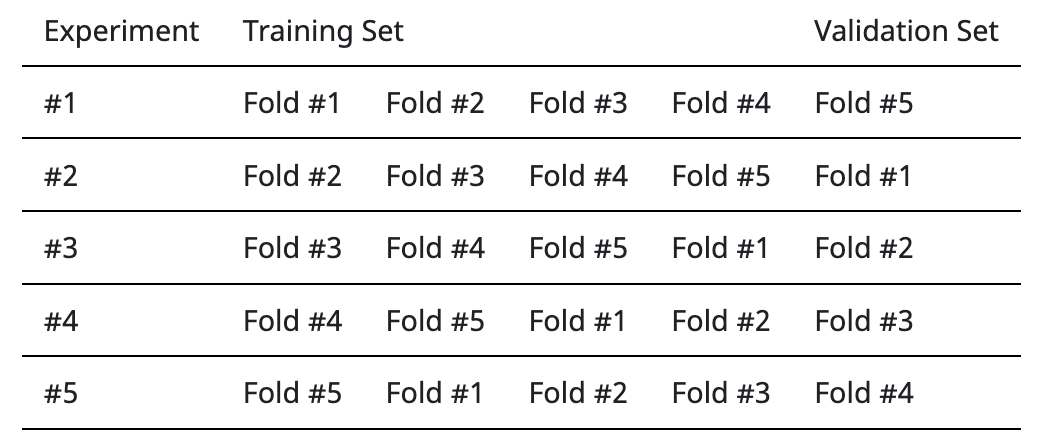

### Create a dictionary param_dist
We will start by creating a dictionary param_dist that will contain all the parameter sets we want to test.

In [7]:
# Import Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define Hyperparameter Ranges
max_depth = list(range(5, 11)) + [None]
min_samples_split = list(range(5, 20))
min_samples_leaf = list(range(2, 15))
max_features = list(range(3, 8))
bootstrap = [True]
max_samples = [0.7, 0.8, 0.9, 0.95, 1]

# Define the Parameter Distribution Dictionary
param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'max_samples': max_samples
}

# Instantiate a Random Forest Regressor with specified hyperparameters and n_estimators=30
forest = RandomForestRegressor(n_estimators=30, n_jobs=1)

# Perform Randomized Search Cross-Validation
forest_cv = RandomizedSearchCV(
    forest, param_dist, cv=6, n_jobs=-1,
    verbose=2, n_iter=400, scoring='neg_mean_absolute_error'
)

# Fit the Randomized Search to the training data
forest_cv.fit(X_train, Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.8, min_samples_leaf=5, min_samples_split=15; total time=   0.2s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.8, min_samples_leaf=5, min_samples_split=15; total time=   0.2s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.8, min_samples_leaf=5, min_samples_split=15; total time=   0.2s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.8, min_samples_leaf=5, min_samples_split=15; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.7, min_samples_leaf=14, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.8, min_samples_leaf=5, min_samples_split=15; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.7, min_samples_leaf=14, min_samples_split=16; total time=   0.1s
[CV] END b

RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': [3, 4, 5, 6, 7],
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14],
                                        'min_samples_split': [5, 6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15, 16, 17, 18,
                                                              19]},
                   scoring='neg_mean_absolute_error', verbose=2)

### Display the accuracy achieved
We can now display the accuracy achieved over the training and the test sets, thanks to our kpi_ML() function.

In [8]:
# Print tuned forest parameters
print('Tuned Forest Parameters:', forest_cv.best_params_)
print()

# Generate predictions for the training and test sets
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

# Calculate Key Performance Indicators (KPIs) using the kpi_ML function
kpi_name = 'Forest | ~ optimized'
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=kpi_name)

Tuned Forest Parameters: {'min_samples_split': 13, 'min_samples_leaf': 10, 'max_samples': 0.8, 'max_features': 6, 'max_depth': None, 'bootstrap': True}

                       MAE  RMSE  Bias
Forest | ~ optimized                  
Train                 14.6  37.6  -0.1
Test                  18.0  45.9   2.7


 ### Feature importance
As a general piece of advice, do not hesitate to plot the feature importance of any new model you create. If you see that some features have minimal importance, try to exclude them. This might make your model faster and more precise (as it will have a limited risk of overfitting).

<Axes: >

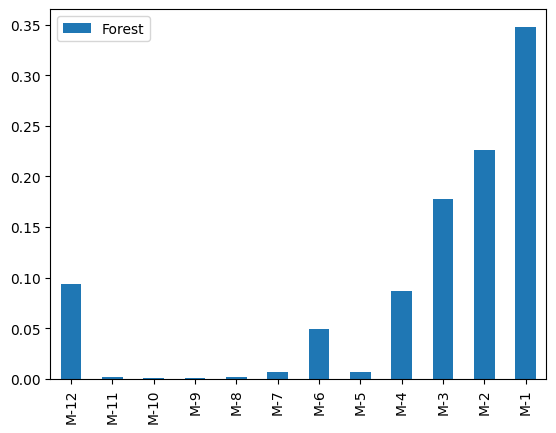

In [9]:
# Get feature importances from the fitted forest_cv model
cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]
data = forest_cv.best_estimator_.feature_importances_.reshape(-1, 1)

# Create a DataFrame with feature importances and corresponding feature names
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])

# Plot the feature importances as a bar chart
imp.plot(kind='bar')
